In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import random
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Define the model
class Net(nn.Module):
  def __init__(self, in_features):
    super().__init__()

    layer1_size = round(in_features - (in_features/3))
    layer2_size = round(in_features - ((2/3)*in_features))
    ##feedfoward layers:
    self.ff1 = nn.Linear(in_features, layer1_size) # input dimension is 2, first hidden layer is 10
    self.ff2 = nn.Linear(layer1_size, layer2_size) # second hidden layer is 2
    self.ff_out = nn.Linear(layer2_size, 1)  # output layer is 1

    ##activation:
    self.act = nn.Sigmoid()

    if torch.cuda.is_available():
      self.cuda()


  def forward(self, input_data):
    input_data = torch.as_tensor(input_data, dtype=torch.float)
    out = self.act(self.ff1(input_data))
    out = self.act(self.ff2(out))
    out = self.ff_out(out)
    return out #returns classification for each image


  def xavier_weights(self):
    nn.init.xavier_uniform_(self.ff1.weight)
    nn.init.xavier_uniform_(self.ff2.weight)
    nn.init.xavier_uniform_(self.ff_out.weight)

In [4]:
# load the data

# Cokie's google drive paths:
data_base_path = '/content/gdrive/MyDrive/ML/CMI-PB Data/data/'
rnaseq_filtered_data_path = data_base_path + 'RNAseqRawBatchCorrectedFiltered.tsv'
rnaseq_metadata_path = data_base_path + 'RNAseqMetaData.tsv'
abtiter_normalized_path = data_base_path + 'AbtiterNormalizedData.tsv'
abtiter_metadata_path = data_base_path + 'AbtiterMetadata.tsv'
cellfreq_normalized_path = data_base_path + 'CytofBatchCorrectedData.tsv'
cellfreq_metadata_path = data_base_path + 'CytofMetadata.tsv'
cytokine_normalized_path = data_base_path + 'CytokineBatchCorrectedData.tsv'
cytokine_metadata_path = data_base_path + 'CytokineMetadata.tsv'

rnaseq_filtered_data_raw = pd.read_csv(rnaseq_filtered_data_path, sep='\t')
rnaseq_metadata = pd.read_csv(rnaseq_metadata_path, sep='\t')
abtiter_normalized_data_raw = pd.read_csv(abtiter_normalized_path, sep='\t')
abtiter_metadata = pd.read_csv(abtiter_metadata_path, sep='\t')
cellfreq_normalized_data_raw = pd.read_csv(cellfreq_normalized_path, sep='\t')
cellfreq_metadata = pd.read_csv(cellfreq_metadata_path, sep='\t')
cytokine_normalized_data_raw = pd.read_csv(cytokine_normalized_path, sep='\t')
cytokine_metadata = pd.read_csv(cytokine_metadata_path, sep='\t')

# skipping additional normalization for now because we are using TMP counts (already normalized)

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/ML/CMI-PB Data/data/RNAseqRawBatchCorrectedFiltered.tsv'

In [ ]:
# see if metadata has the right number of individuals
rnaseq_test0 = rnaseq_metadata.drop_duplicates(subset=['subject_id'])
print(rnaseq_test0.shape)
numSamples = 72

abtiter_test0 = abtiter_metadata.drop_duplicates(subset=['subject_id'])
print(abtiter_test0.shape)

cellfreq_test0 = cellfreq_metadata.drop_duplicates(subset=['subject_id'])
print(cellfreq_test0.shape)

cytokine_test0 = cytokine_metadata.drop_duplicates(subset=['subject_id'])
print(cytokine_test0.shape)

In [ ]:
# load data for rnaseq
rnaseq_metadata_subset = rnaseq_metadata[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
data_transposed = rnaseq_filtered_data_raw.T
data_transposed.index.name = 'specimen_id'
data_transposed.reset_index(inplace=True)
data_transposed['specimen_id'] = pd.to_numeric(data_transposed['specimen_id'])
data_merged = data_transposed.merge(rnaseq_metadata_subset, how='left', on='specimen_id')
data_merged_subsetted = data_merged[data_merged['planned_day_relative_to_boost'].isin([0, 3])]

print("All data points (input and output), should be 144 long: ", data_merged_subsetted.shape)

# format data and split into input and output (x and y, input and label)
data_groups = data_merged_subsetted.groupby('planned_day_relative_to_boost')
data_x = data_groups.get_group(0).drop(['planned_day_relative_to_boost'], axis=1)
data_y = data_groups.get_group(3)[['ENSG00000277632.1', 'subject_id']]
data_x.sort_values(by='subject_id', inplace=True)
data_y.sort_values(by='subject_id', inplace=True)

print("All input (x) data points, should be 72 long: ", data_x.shape)
print("All output (y, label) data points, should be 72 long: ", data_y.shape)

# split data into training and testing
numTrain = round(numSamples * 0.9)
numTest = numSamples - numTrain

training_data_x = data_x.head(numTrain)
training_data_y = data_y.head(numTrain)
test_data_x = data_x.tail(numTest)
test_data_y = data_y.tail(numTest)

print("Training x and y still in same order: ", training_data_x['subject_id'].tolist() == training_data_y['subject_id'].tolist())
print("Test x and y still in same order: ", test_data_x['subject_id'].tolist() == test_data_y['subject_id'].tolist())

In [ ]:
print(training_data_x.shape)
print(training_data_y.shape)

print(test_data_x.shape)
print(test_data_y.shape)

In [ ]:
# Define your dataloaders
tensor_X_train = torch.Tensor(training_data_x.to_numpy())
tensor_Y_train = torch.Tensor(training_data_y.to_numpy())
tensor_X_test = torch.Tensor(test_data_x.to_numpy())
tensor_Y_test = torch.Tensor(test_data_y.to_numpy())

train_dataset = TensorDataset(tensor_X_train, tensor_Y_train)
test_dataset = TensorDataset(tensor_X_test, tensor_Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size = 300, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size = 300, shuffle=False)

In [ ]:
# function for training model
def train_model(model, train_loader, test_loader, epochs=300, seed=3):

  # keep output fixed
  torch.manual_seed(seed)
  random.seed(seed)

  # reset parameters
  model.xavier_weights()

  plot_data = []

  for epoch in range(epochs):
    # debug
    print(epoch)

    tot_train_loss = 0
    tot_train_err = 0
    tot_test_err = 0

    # calculate training loss and acc
    for x_train, y_train in train_loader:
      # print(x_train.shape)
      # print(y_train.shape)

      x_train, y_train = x_train.to(device), y_train.to(device)

      optimizer.zero_grad()

      yhat = model(x_train)
      loss = loss_metric(yhat, y_train.unsqueeze(1))

      # debug
      # print("yhat: ", yhat, ". yhat type: ", type(yhat))
      # print("y_train: ", y_train, ". y_train type: ", type(yhat))

      epoch_train_err = calc_err(yhat,y_train.unsqueeze(1))
      loss.backward()
      optimizer.step()

      tot_train_loss += loss.item()
      tot_train_err += epoch_train_err.item()

    # calculate testing loss and acc
    model.eval()
    with torch.no_grad():
      for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        yhat = model(x_test)

        epoch_test_err = calc_err(yhat, y_test.unsqueeze(1))

        tot_test_err += epoch_test_err.item()

    plot_data.append([epoch, tot_train_loss/len(train_loader), tot_train_err/len(train_loader), tot_test_err/len(test_loader)])
    print(f'Epoch {epoch+0:03}: | Loss: {tot_train_loss/len(train_loader):.5f} | Err: {tot_train_err/len(train_loader):.3f} | TestErr: {tot_test_err/len(test_loader):.3f}')

  return plot_data

# TODO: is this the right accuracy metric for continuous variables? how do I use MSE to get accuracy?
# define training and test loss/accuracy functions
def calc_acc(y_pred, y_test):
  y_pred_tag = torch.round(y_pred)

  correct_results_sum = (y_pred_tag == y_test).sum().float()
  acc = correct_results_sum/y_test.shape[0]

  return acc

def calc_err(y_pred, y_test):
  err = (torch.sum(torch.square(torch.subtract(y_pred, y_test))))

  return err

# Function to plot data for a certain seed
def plot_loss_acc(plot_data, index):
  plt.figure(index)
  ax = plt.gca()

  # change plot_data into a np array
  data = np.array(plot_data)
  x = data[:,0]           # first column is the epoch count
  train_loss = data[:,1]  # second column is train loss
  train_acc = data[:,2]   # 3rd column is train accuracy
  test_acc = data[:,3]    # 4th column is test accuracy

  ax.plot(train_loss, label = 'Train Loss')
  ax.plot(test_acc, label = 'Test Error')
  ax.legend()
  # ax.set_ylim([0.0, 1.0])
  plt.xlabel('Epochs')
  plt.title('Train Loss and Test Error for Seed %d' %index)

In [1]:
# instantiate model
rnaseq_net = Net(8244)
rnaseq_net.to(device)

# define optimizer and loss
# TODO: consider using adam optimizer
optimizer = torch.optim.SGD(rnaseq_net.parameters(), lr = 0.00001, weight_decay=0.001)
loss_metric = nn.MSELoss()

# train model using 5 random seeds
train_accuracies = []
test_accuracies = []
epochs = 100
for i in range(1):
  plot_data=train_model(rnaseq_net, train_loader, test_loader, epochs, i)

  train_accuracies.append(np.array(plot_data)[(epochs - 1),2])
  test_accuracies.append(np.array(plot_data)[(epochs - 1),3])

  plot_loss_acc(plot_data, i)

NameError: name 'Net' is not defined

In [ ]:
# Test accuracy on test set
print("train mean:", np.mean(train_accuracies))
print("train stddv:", np.std(train_accuracies))
print("test mean:", np.mean(test_accuracies))
print("test stddv:", np.std(test_accuracies))

train mean: 484265952.0
train stddv: 0.0
test mean: 250380.171875
test stddv: 0.0


Now train the same model but on input=(abtiters, cell frequency, cytokine concentrations) and output=(Pertussis Toxin (PT) IgG titers):

In [ ]:
## load data for abtiters
abtiter_metadata_subset = abtiter_metadata[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
abtiter_data_transposed = abtiter_normalized_data_raw.T
abtiter_data_transposed.index.name = 'specimen_id'
abtiter_data_transposed.reset_index(inplace=True)
abtiter_data_transposed['specimen_id'] = pd.to_numeric(abtiter_data_transposed['specimen_id'])
abtiter_data_merged = abtiter_data_transposed.merge(abtiter_metadata_subset, how='left', on='specimen_id')
abtiter_data_merged_subsetted = abtiter_data_merged[abtiter_data_merged['planned_day_relative_to_boost'].isin([0, 14])]

print("All abtiter data points (input and output), should be 180 long: ", abtiter_data_merged_subsetted.shape)

## load data for cell frequency
cellfreq_metadata_subset = cellfreq_metadata[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
cellfreq_data_transposed = cellfreq_normalized_data_raw.T
cellfreq_data_transposed.index.name = 'specimen_id'
cellfreq_data_transposed.reset_index(inplace=True)
cellfreq_data_transposed['specimen_id'] = pd.to_numeric(cellfreq_data_transposed['specimen_id'])
cellfreq_data_merged = cellfreq_data_transposed.merge(cellfreq_metadata_subset, how='left', on='specimen_id')
cellfreq_data_merged_subsetted = cellfreq_data_merged[cellfreq_data_merged['planned_day_relative_to_boost'].isin([0, 14])]

print("All cell freq data points (input and output), should be 106 long: ", cellfreq_data_merged_subsetted.shape)

## load data for cytokine concentrations
cytokine_metadata_subset = cytokine_metadata[['specimen_id', 'subject_id', 'planned_day_relative_to_boost']]
cytokine_data_transposed = cytokine_normalized_data_raw.T
cytokine_data_transposed.index.name = 'specimen_id'
cytokine_data_transposed.reset_index(inplace=True)
cytokine_data_transposed['specimen_id'] = pd.to_numeric(cytokine_data_transposed['specimen_id'])
cytokine_data_merged = cytokine_data_transposed.merge(cytokine_metadata_subset, how='left', on='specimen_id')
cytokine_data_merged_subsetted = cytokine_data_merged[cytokine_data_merged['planned_day_relative_to_boost'].isin([0, 14])]

print("All cytokine data points (input and output), should be 108 long: ", cytokine_data_merged_subsetted.shape)

All abtiter data points (input and output), should be 180 long:  (181, 30)
All cell freq data points (input and output), should be 106 long:  (106, 23)
All cytokine data points (input and output), should be 108 long:  (108, 33)


In [ ]:
# combine the data types by including only the subjects that are
# complete (0 and 14 time point), and which have values for cell freq, cytokines, and abtiters
subject_dict = {}
for index, row in abtiter_data_merged_subsetted.iterrows():
  if row['subject_id'] in subject_dict:
    subject_dict[row['subject_id']] = subject_dict[row['subject_id']] + 1
  else:
    subject_dict[row['subject_id']] = 1

completeSubjects = []
for elem in subject_dict:
  if subject_dict[elem] == 2:
    completeSubjects.append(elem)

def intersection(lst1, lst2):
  lst3 = [value for value in lst1 if value in lst2]
  return lst3

subject_intersection = intersection(
    abtiter_data_merged_subsetted['subject_id'].tolist(),
    cellfreq_data_merged_subsetted['subject_id'].tolist()
    )
subject_intersection = intersection(subject_intersection, cytokine_data_merged_subsetted['subject_id'].tolist())
subject_intersection = intersection(subject_intersection, completeSubjects)
print("length of subject intersection: ", len(subject_intersection))

## combine abtiter, cell frequency, cytokine concentrations
# there are not the same number of individuals, first remove abtiter specimens that are not
# present in cellfreq and cytokine.
abtiter_mask = abtiter_data_merged_subsetted['subject_id'].isin(subject_intersection)
abtiter_data_reduced = abtiter_data_merged_subsetted[abtiter_mask]

cellfreq_mask = cellfreq_data_merged_subsetted['subject_id'].isin(subject_intersection)
cellfreq_data_reduced = cellfreq_data_merged_subsetted[cellfreq_mask]

cytokine_mask = cytokine_data_merged_subsetted['subject_id'].isin(subject_intersection)
cytokine_data_reduced = cytokine_data_merged_subsetted[cytokine_mask]

reduced_titerPred_data = pd.merge(abtiter_data_merged_subsetted, cellfreq_data_merged_subsetted, how='left', on='specimen_id')
reduced_titerPred_data = pd.merge(reduced_titerPred_data, cytokine_data_merged_subsetted, how='left', on='specimen_id')

length of subject intersection:  96


In [ ]:
print(abtiter_data_reduced.shape)
print(cellfreq_data_reduced.shape)
print(cytokine_data_reduced.shape)
print(reduced_titerPred_data.shape)

(96, 30)
(96, 23)
(96, 33)
(181, 84)


In [ ]:
# format data and split into input and output (x and y, input and label)
combined_data_groups = reduced_titerPred_data.groupby('planned_day_relative_to_boost')
data_x = combined_data_groups.get_group(0).drop(['planned_day_relative_to_boost', 'IgG_PT'], axis=1)
data_y = combined_data_groups.get_group(14)[['IgG_PT', 'subject_id']]
data_x.sort_values(by='subject_id', inplace=True)
data_y.sort_values(by='subject_id', inplace=True)

print("All input (x) data points, should be 48 long: ", data_x.shape)
print("All output (y, label) data points, should be 48 long: ", data_y.shape)

# split data into training and testing
abtiterPred_nSamples = 47
numTrain = round(abtiterPred_nSamples * 0.9)
numTest = abtiterPred_nSamples - numTrain

training_data_x = data_x.head(numTrain)
training_data_y = data_y.head(numTrain)
test_data_x = data_x.tail(numTest)
test_data_y = data_y.tail(numTest)

print(
    "Training x and y still in same order: ",
    training_data_x['subject_id'].tolist() == training_data_y['subject_id'].tolist()
    )
print(
    "Test x and y still in same order: ",
    test_data_x['subject_id'].tolist() == test_data_y['subject_id'].tolist()
    )

# Define your dataloaders
tensor_X_train = torch.Tensor(training_data_x.to_numpy())
tensor_Y_train = torch.Tensor(training_data_y.to_numpy())
tensor_X_test = torch.Tensor(test_data_x.to_numpy())
tensor_Y_test = torch.Tensor(test_data_y.to_numpy())

train_dataset = TensorDataset(tensor_X_train, tensor_Y_train)
test_dataset = TensorDataset(tensor_X_test, tensor_Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size = 300, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size = 300, shuffle=False)

All input (x) data points, should be 48 long:  (51, 82)
All output (y, label) data points, should be 48 long:  (51, 2)
Training x and y still in same order:  True
Test x and y still in same order:  True


In [ ]:
# instantiate model
abtiters_net = Net(82)
abtiters_net.to(device)

# define optimizer and loss
# TODO: consider using adam optimizer
optimizer = torch.optim.SGD(abtiters_net.parameters(), lr = 0.0001, weight_decay=0.001)
loss_metric = nn.MSELoss()

In [ ]:
# train model using 5 random seeds
train_accuracies = []
test_accuracies = []
epochs = 1000
for i in range(1):
  plot_data=train_model(abtiters_net, train_loader, test_loader, epochs, i)

  train_accuracies.append(np.array(plot_data)[(epochs - 1),2])
  test_accuracies.append(np.array(plot_data)[(epochs - 1),3])

  plot_loss_acc(plot_data, i)

0
Epoch 000: | Loss: nan | Err: nan | TestErr: nan
1
Epoch 001: | Loss: nan | Err: nan | TestErr: nan
2
Epoch 002: | Loss: nan | Err: nan | TestErr: nan
3
Epoch 003: | Loss: nan | Err: nan | TestErr: nan
4
Epoch 004: | Loss: nan | Err: nan | TestErr: nan
5
Epoch 005: | Loss: nan | Err: nan | TestErr: nan
6
Epoch 006: | Loss: nan | Err: nan | TestErr: nan
7
Epoch 007: | Loss: nan | Err: nan | TestErr: nan
8
Epoch 008: | Loss: nan | Err: nan | TestErr: nan
9
Epoch 009: | Loss: nan | Err: nan | TestErr: nan
10
Epoch 010: | Loss: nan | Err: nan | TestErr: nan
11
Epoch 011: | Loss: nan | Err: nan | TestErr: nan
12
Epoch 012: | Loss: nan | Err: nan | TestErr: nan
13
Epoch 013: | Loss: nan | Err: nan | TestErr: nan
14
Epoch 014: | Loss: nan | Err: nan | TestErr: nan
15
Epoch 015: | Loss: nan | Err: nan | TestErr: nan
16
Epoch 016: | Loss: nan | Err: nan | TestErr: nan
17
Epoch 017: | Loss: nan | Err: nan | TestErr: nan
18
Epoch 018: | Loss: nan | Err: nan | TestErr: nan
19
Epoch 019: | Loss: 

NameError: name 'plot_loss_acc' is not defined

Now re-run day 14 IgG-PT abtiter values for input data that has imputed values instead of cutting out all samples that dont have an entry for every datatype.

In [ ]:
# combine the data types by imputing any values that are missing for
# cell freq, cytokines, abtiters, for day 0 or 14 time points
all_titerPred_data = pd.merge(abtiter_data_transposed, cellfreq_data_transposed, how='left', on='specimen_id')
all_titerPred_data = pd.merge(all_titerPred_data, cytokine_data_transposed, how='left', on='specimen_id')
all_titerPred_data['specimen_id'] = pd.to_numeric(abtiter_data_transposed['specimen_id'])
all_titerPred_merged_metadata = all_titerPred_data.merge(abtiter_metadata_subset, how='left', on='specimen_id')
all_titerPred_time_subset = all_titerPred_merged_metadata[all_titerPred_merged_metadata['planned_day_relative_to_boost'].isin([0, 14])]

# make sure data only has complete sets of timepoint 0 and 14 for each subject
subject_dict = {}
for index, row in all_titerPred_time_subset.iterrows():
  if row['subject_id'] in subject_dict:
    subject_dict[row['subject_id']] = subject_dict[row['subject_id']] + 1
  else:
    subject_dict[row['subject_id']] = 1

completeSubjects = []
for elem in subject_dict:
  if subject_dict[elem] == 2:
    completeSubjects.append(elem)

all_titerPred_mask = all_titerPred_time_subset['subject_id'].isin(completeSubjects)
all_titerPred_complete = all_titerPred_time_subset[all_titerPred_mask]

# split data into input (x), and output (y, label)
combined_toImpute_titerPred = all_titerPred_complete.groupby('planned_day_relative_to_boost')
data_x = combined_toImpute_titerPred.get_group(0).drop(['planned_day_relative_to_boost', 'IgG_PT'], axis=1)
data_y = combined_toImpute_titerPred.get_group(14)[['IgG_PT', 'subject_id']]
data_x.sort_values(by='subject_id', inplace=True)
data_y.sort_values(by='subject_id', inplace=True)

data_x = data_x.drop(['subject_id'], axis=1)
data_y = data_y.drop(['subject_id'], axis=1)

print("All input (x) data points, should be 90 long: ", data_x.shape)
print("All output (y, label) data points, should be 90 long: ", data_y.shape)

x_train, x_test , y_train , y_test = train_test_split(data_x, data_y, test_size=0.1, random_state=42)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

# impute missing data
imputer = SimpleImputer(strategy='median')
x_train_imputed = imputer.fit_transform(x_train)
x_test_imputed = imputer.transform(x_test)

print("x_train imputed shape: ", x_train_imputed.shape)
print("x_test imputed shape: ", x_test_imputed.shape)

All input (x) data points, should be 90 long:  (90, 77)
All output (y, label) data points, should be 90 long:  (90, 1)
x_train shape:  (81, 77)
x_test shape:  (9, 77)
y_train shape:  (81, 1)
y_test shape:  (9, 1)
x_train imputed shape:  (81, 77)
x_test imputed shape:  (9, 77)


0
Epoch 000: | Loss: 65.70869 | Err: 23038.937 | TestErr: 7758.678
1
Epoch 001: | Loss: 64.18266 | Err: 22527.553 | TestErr: 7624.312
2
Epoch 002: | Loss: 62.73362 | Err: 22085.374 | TestErr: 7504.795
3
Epoch 003: | Loss: 61.40513 | Err: 21668.679 | TestErr: 7420.263
4
Epoch 004: | Loss: 60.43041 | Err: 21351.372 | TestErr: 7339.375
5
Epoch 005: | Loss: 59.51811 | Err: 21052.234 | TestErr: 7260.848
6
Epoch 006: | Loss: 58.63498 | Err: 20762.342 | TestErr: 7183.755
7


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 007: | Loss: 57.76896 | Err: 20477.701 | TestErr: 7106.482
8
Epoch 008: | Loss: 56.90783 | Err: 20193.655 | TestErr: 7027.886
9
Epoch 009: | Loss: 56.06905 | Err: 19917.317 | TestErr: 6954.277
10
Epoch 010: | Loss: 55.26580 | Err: 19654.044 | TestErr: 6883.321
11
Epoch 011: | Loss: 54.48663 | Err: 19399.287 | TestErr: 6814.077
12
Epoch 012: | Loss: 53.72647 | Err: 19151.045 | TestErr: 6746.233
13
Epoch 013: | Loss: 52.98296 | Err: 18908.400 | TestErr: 6679.633
14
Epoch 014: | Loss: 52.25433 | Err: 18670.660 | TestErr: 6614.198
15
Epoch 015: | Loss: 51.53928 | Err: 18437.326 | TestErr: 6549.885
16
Epoch 016: | Loss: 50.83700 | Err: 18208.092 | TestErr: 6486.675
17
Epoch 017: | Loss: 50.14726 | Err: 17982.878 | TestErr: 6424.554
18
Epoch 018: | Loss: 49.47050 | Err: 17761.878 | TestErr: 6363.509
19
Epoch 019: | Loss: 48.80674 | Err: 17545.112 | TestErr: 6303.521
20
Epoch 020: | Loss: 48.15492 | Err: 17332.182 | TestErr: 6244.566
21
Epoch 021: | Loss: 47.51412 | Err: 17122.723 | Tes

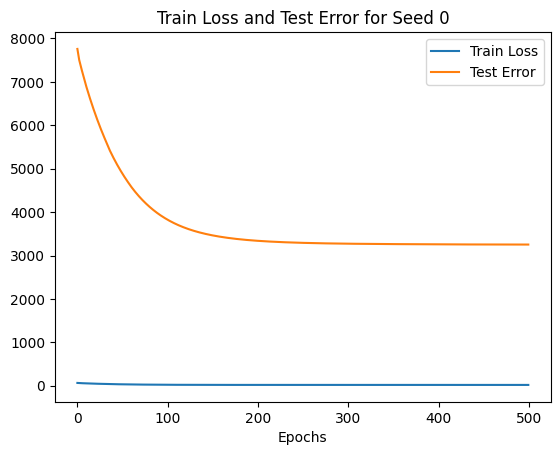

In [ ]:
# Define your dataloaders
tensor_X_train = torch.Tensor(x_train_imputed)
tensor_Y_train = torch.Tensor(y_train.to_numpy())
tensor_X_test = torch.Tensor(x_test_imputed)
tensor_Y_test = torch.Tensor(y_test.to_numpy())

train_dataset = TensorDataset(tensor_X_train, tensor_Y_train)
test_dataset = TensorDataset(tensor_X_test, tensor_Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size = 20, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size = 20, shuffle=False)

# instantiate model
abtiters_imputed_net = Net(77)
abtiters_imputed_net.to(device)

# define optimizer and loss
# TODO: consider using adam optimizer
optimizer = torch.optim.SGD(abtiters_imputed_net.parameters(), lr = 1e-4, weight_decay=0.001)
loss_metric = nn.MSELoss()

# train model using 5 random seeds
train_accuracies = []
test_accuracies = []
epochs = 500
for i in range(1):
  plot_data=train_model(abtiters_imputed_net, train_loader, test_loader, epochs, i)

  train_accuracies.append(np.array(plot_data)[(epochs - 1),2])
  test_accuracies.append(np.array(plot_data)[(epochs - 1),3])

  plot_loss_acc(plot_data, i)

In [ ]:
print(y_test)
print(np.mean(y_test))

        IgG_PT
282  16.017096
150   1.258965
384  19.236953
489   3.420820
23   10.874112
182   4.092597
273   1.444783
454  10.201331
95    3.164491
IgG_PT    7.745683
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
